In [1]:
import sys
sys.path.append('../..')
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import torchvision
from DLBio.pytorch_helpers import get_device
import numpy as np
import matplotlib.pyplot as plt
import ds_ear_siamese
import transforms_data as td
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss
from torch import cuda
from NN_Siamese import SiameseNetwork

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
# Set Up All Configurations here
class Config():
    NN_SIAMESE = False
    dataset_dir = '../dataset_low_res/'
    # training_dir = "../data/ears/training/"
    # testing_dir = "../data/ears/testing/"
    train_batch_size = 32
    test_batch_size = 1
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS= 100
    LEARNINGRATE = 0.001
    WEIGHT_DECAY = 1

In [4]:
# define indicies to split Data
N = len(ds_ear_siamese.get_dataset(data_path=Config.dataset_dir, transform_mode='size_only'))
print(N)
n_80 = int(round(.8*N))
n_70 = int(round(.7*N))
n_60 = int(round(.6*N))

rand_indices = np.random.permutation(N)
train_indices = rand_indices[:n_70]
test_indices = rand_indices[n_70:]

# definde data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = ds_ear_siamese.get_dataloader(
    indices=train_indices,
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese', # TODO switch to another transform? 
    data_path=Config.dataset_dir
)

# dl_test = ds_ear_siamese.get_dataloader(
test_dataloader = ds_ear_siamese.get_dataloader(
    indices=test_indices,
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    data_path=Config.dataset_dir
)

vis_dataloader = ds_ear_siamese.get_dataloader(
    indices=train_indices,
    batch_size=Config.vis_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    data_path=Config.dataset_dir
)

['alissa_buh', 'falco_len', 'gregor_spi', 'janna_qua', 'jesse_kru', 'johannes_boe', 'johannes_wie', 'konrad_von', 'mila_wol', 'nils_loo', 'sarah_feh', 'tim_moe']
960


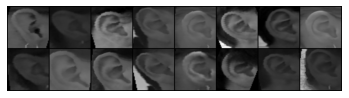

[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [5]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
# Definde Model and load to device
if Config.NN_SIAMESE == False:
    model = mobilenet_v2(pretrained=True)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=5)

    layers = []
    for layer in model.features[0]:
        layers.append(layer)
    model.features[0][0] = nn.ReflectionPad2d(1)
    model.features[0][1] = layers[0]
    model.features[0][2] = layers[1]
    model.features[0].add_module('3', layers[2])
else:
    model = SiameseNetwork()


device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss(2.0)
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)



cuda:0


Epoch number 0
 Current loss 1.3918427228927612

Epoch number 0
 Current loss 2.510878562927246

Epoch number 0
 Current loss 1.7531275749206543

Epoch number 1
 Current loss 1.0706050395965576

Epoch number 1
 Current loss 0.7878551483154297

Epoch number 1
 Current loss 0.9712260365486145

Epoch number 2
 Current loss 0.8132344484329224

Epoch number 2
 Current loss 1.2750701904296875

Epoch number 2
 Current loss 0.8860582113265991

Epoch number 3
 Current loss 1.146971344947815

Epoch number 3
 Current loss 0.5812680721282959

Epoch number 3
 Current loss 0.9507324695587158

Epoch number 4
 Current loss 0.8135319352149963

Epoch number 4
 Current loss 0.6193865537643433

Epoch number 4
 Current loss 0.5304896831512451

Epoch number 5
 Current loss 0.5493724346160889

Epoch number 5
 Current loss 0.6200276613235474

Epoch number 5
 Current loss 0.5881094932556152

Epoch number 6
 Current loss 0.5099654197692871

Epoch number 6
 Current loss 0.4066174030303955

Epoch number 6
 Curren

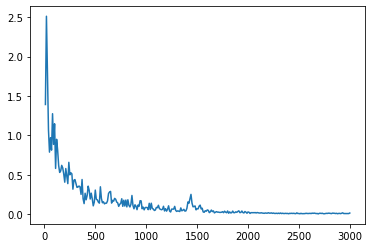

In [7]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, 
                loss_contrastive=contrastive_loss_siamese, nn_Siamese=Config.NN_SIAMESE)

counter, loss_history = training(Config.EPOCHS)
show_plot(counter, loss_history)

In [8]:
if Config.NN_SIAMESE:
    def generate_output( img_in, img_in2):
        if cuda.is_available():
            return model(Variable(img_in).cuda(), Variable(img_in2).cuda())
        else:
            return model(Variable(img_in), Variable(img_in2))

else:
    def generate_output( img_in):
        if cuda.is_available():
            return model(Variable(img_in).cuda())
        else:
            return model(Variable(img_in))         

In [9]:
iter_batches = iter(test_dataloader)
accuracy_count = 0.0
matches = []
non_matches = []
for i in range(len(iter_batches)):
    # batch size schould be 1 to throw no errors in accessing the next(iter_batches) 
    img0, img1, label = next(iter_batches)
    # appends images to matches, if label is 0 (0 = same)
    ((matches, non_matches)[int(label)]).append( (img0,img1) )

# iterate through both lists and compare the distances of the current entries
for m, n in zip(matches, non_matches):
    # get the models output vectors for the images
    
    if Config.NN_SIAMESE:
        match_out1, match_out2 = generate_output(m[0], m[1])
        non_match_out1, non_match_out2 = generate_output(n[0], n[1])
    else:
        match_out1 = generate_output(m[0])
        match_out2 = generate_output(m[1])                 
        non_match_out1 = generate_output(n[0])
        non_match_out2 = generate_output(n[1])
        
    # positive-positive, positive-negative distance
    euclidean_distance_pp = F.pairwise_distance(match_out1, match_out2)
    euclidean_distance_pn = F.pairwise_distance(non_match_out1, non_match_out2)
    
    # format variables
    fmt_id = '{:<12}'
    fmt_eucl = '{:<.3f}'
    # increase accouracy count if p-p was lower than p-n
    if(euclidean_distance_pp < euclidean_distance_pn): accuracy_count += 1
    # print current stats
    print(fmt_id.format('pos-pos: '), fmt_eucl.format( euclidean_distance_pp.item()) )
    print(fmt_id.format('pos-neg: '),fmt_eucl.format( euclidean_distance_pn.item()) )
    print(fmt_id.format('Acc. count: '), '{:>.0f}'.format(accuracy_count), '\n')

# divide by the minimum length (zip function regulated the steps to the minimum)
print(fmt_id.format('Overall (estimated) accuracy: '), fmt_eucl.format( 100 * accuracy_count / min(len(matches), len(non_matches)) ), ' %')

pos-pos:     0.330
pos-neg:     0.854
Acc. count:  1 

pos-pos:     0.460
pos-neg:     1.734
Acc. count:  2 

pos-pos:     0.136
pos-neg:     1.454
Acc. count:  3 

pos-pos:     0.443
pos-neg:     1.897
Acc. count:  4 

pos-pos:     0.305
pos-neg:     1.435
Acc. count:  5 

pos-pos:     0.188
pos-neg:     1.015
Acc. count:  6 

pos-pos:     0.241
pos-neg:     2.373
Acc. count:  7 

pos-pos:     1.267
pos-neg:     1.627
Acc. count:  8 

pos-pos:     0.241
pos-neg:     0.399
Acc. count:  9 

pos-pos:     0.309
pos-neg:     0.835
Acc. count:  10 

pos-pos:     0.379
pos-neg:     1.130
Acc. count:  11 

pos-pos:     0.165
pos-neg:     1.215
Acc. count:  12 

pos-pos:     0.171
pos-neg:     1.905
Acc. count:  13 

pos-pos:     0.114
pos-neg:     0.743
Acc. count:  14 

pos-pos:     0.361
pos-neg:     0.717
Acc. count:  15 

pos-pos:     0.204
pos-neg:     0.716
Acc. count:  16 

pos-pos:     0.242
pos-neg:     0.512
Acc. count:  17 

pos-pos:     0.942
pos-neg:     1.391
Acc. count:  18 

p

In [ ]:
#model = torch.load('/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')

In [10]:
torch.save(model,'/nfshome/vkuegelgen/Documents/Bachelorarbeit/Bachelorthesis/models/model_mobile_ALL_95percent.pt')